## This model will clasify a potato leaf has either early blight or late blight disease.
Version 01 :
1. Model : Custom
2. Diseaseses : 2 (early / late blight)
3. Dataset : Potato_blight_disease_dataset

In [77]:
# Import libraries

import tensorflow as tf
from tensorflow.keras import models, layers
import numpy as np
import matplotlib.pyplot as plt
import os
import cv2 as cv

### Importing all the data

In [4]:
PATH = 'Datasets//Potato_blight_disease_dataset'
IMAGE_SIZE = 256
BATCH_SIZE = 32
CHANELS = 3
EPOCHS = 60

In [5]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    PATH,
    shuffle=True,
    image_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

Found 2284 files belonging to 3 classes.


In [6]:
class_names = dataset.class_names
class_names

['Early_blight', 'Late_blight', 'healthy']

In [7]:
N_CLASSES = len(class_names)
N_CLASSES

3

In [8]:
len(dataset)

#This means there are 72 batches each containing 32 images

72

2025-12-24 22:56:15.047058: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


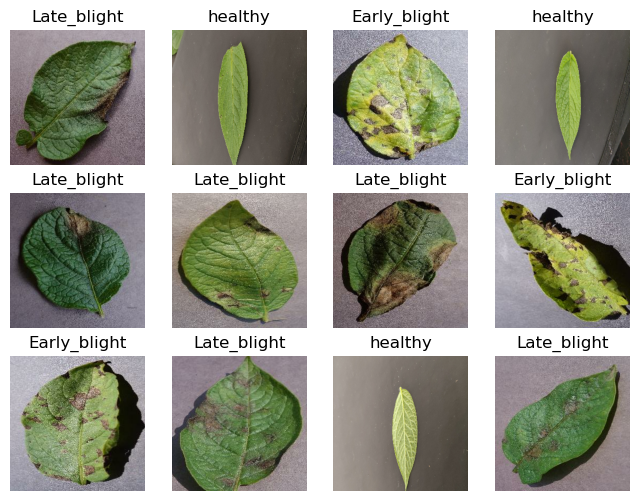

In [9]:
plt.figure(figsize=(8,6))

for image_batch, lable_batch in dataset.take(1):
    for i in range(12):
        ax = plt.subplot(3, 4, i+1)
        plt.imshow(image_batch[i].numpy().astype('uint8'))
        plt.title(class_names[lable_batch[i]])
        plt.axis('off')

In [10]:
#Split the data set into train, test and validation sets.

def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=1000):
    
    num_batches = len(ds)
    train_size = int(num_batches*train_split)
    val_size = int(num_batches*val_split)

    if shuffle:
        ds.shuffle(shuffle_size, seed=12)
    
    train_ds = ds.take(train_size)
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)

    print('Data partitions are created.')
    print(f'Train size = {len(train_ds)} \nValidation size = {len(val_ds)} \nTest size = {len(test_ds)}')

    return train_ds, val_ds, test_ds

In [11]:
train_ds, validation_ds, test_ds = get_dataset_partitions_tf(dataset)

Data partitions are created.
Train size = 57 
Validation size = 7 
Test size = 8


In [12]:
#Set datasets to be cached and work with multi processing

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
validation_ds = validation_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

### Setting up preprocessing

In [14]:
#Resize any given image to 256x256 and sacle teh image values to 0:1

resize_and_rescale = tf.keras.Sequential([
    layers.Resizing(IMAGE_SIZE, IMAGE_SIZE),
    layers.Rescaling(1.0/255)
])

In [15]:
#Setting data augmentation (Increase)

data_augmentation = tf.keras.Sequential([
    layers.RandomBrightness(0.2),
    layers.RandomContrast(0.2),
    layers.RandomFlip(),
    layers.RandomRotation(0.2),
])

In [66]:
data_augmentation_2 = tf.keras.Sequential([
    layers.RandomFlip(),
    layers.RandomRotation(0.2),
])

### Model building and training

In [17]:
# Model building
INPUT_SHAPE = (IMAGE_SIZE, IMAGE_SIZE, CHANELS)

model_1 = tf.keras.Sequential([
    layers.Input(shape=(None, None, 3)),
    
    resize_and_rescale,
    data_augmentation,
    
    layers.Conv2D(32, (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(N_CLASSES, activation='softmax')
])

model_1.build()

In [18]:
model_1.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential (Sequential)         │ (None, 256, 256, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_1 (Sequential)       │ (None, 256, 256, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 254, 254, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 127, 127, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 125, 125, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 62, 62, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 60, 60, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 28, 28, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 12, 12, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 6, 6, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 4, 4, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 2, 2, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │        16,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 3)              │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 183,747 (717.76 KB)

 Trainable params: 183,747 (717.76 KB)

 Non-trainable params: 0 (0.00 B)

In [56]:
def save_model(model, name, model_version):
    model.save(f'Models//{name}//{model_version}.keras')
    print('Model saved succesfully')

In [20]:
model_1.compile(
    optimizer='adam',
    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

history_model_1 = model_1.fit(
    train_ds,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    verbose=1,
    validation_data=validation_ds
)

save_model(model_1, 'potato_earlyblight_lateblight_healthy_custom_model')

Epoch 1/60
57/57 ━━━━━━━━━━━━━━━━━━━━ 31s 500ms/step - accuracy: 0.4386 - loss: 1.0446 - val_accuracy: 0.4018 - val_loss: 0.9796
Epoch 2/60
57/57 ━━━━━━━━━━━━━━━━━━━━ 27s 469ms/step - accuracy: 0.4375 - loss: 1.0022 - val_accuracy: 0.5045 - val_loss: 0.9213
Epoch 3/60
57/57 ━━━━━━━━━━━━━━━━━━━━ 27s 480ms/step - accuracy: 0.4232 - loss: 0.9958 - val_accuracy: 0.4911 - val_loss: 0.9258
Epoch 4/60
57/57 ━━━━━━━━━━━━━━━━━━━━ 27s 482ms/step - accuracy: 0.4359 - loss: 0.9878 - val_accuracy: 0.5089 - val_loss: 0.9327
Epoch 5/60
57/57 ━━━━━━━━━━━━━━━━━━━━ 27s 477ms/step - accuracy: 0.4331 - loss: 0.9848 - val_accuracy: 0.4777 - val_loss: 0.9446
Epoch 6/60
57/57 ━━━━━━━━━━━━━━━━━━━━ 27s 476ms/step - accuracy: 0.4397 - loss: 0.9813 - val_accuracy: 0.4018 - val_loss: 0.9498
Epoch 7/60
57/57 ━━━━━━━━━━━━━━━━━━━━ 28s 490ms/step - accuracy: 0.4545 - loss: 0.9783 - val_accuracy: 0.5045 - val_loss: 0.9250
Epoch 8/60
57/57 ━━━━━━━━━━━━━━━━━━━━ 27s 470ms/step - accuracy: 0.4309 - loss: 0.9807 - val_accu

In [21]:
score = model_1.evaluate(test_ds)
score

8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 122ms/step - accuracy: 0.4068 - loss: 0.9826


[0.9826074242591858, 0.4067796468734741]

Text(0.5, 1.0, 'Training and Validation loss')

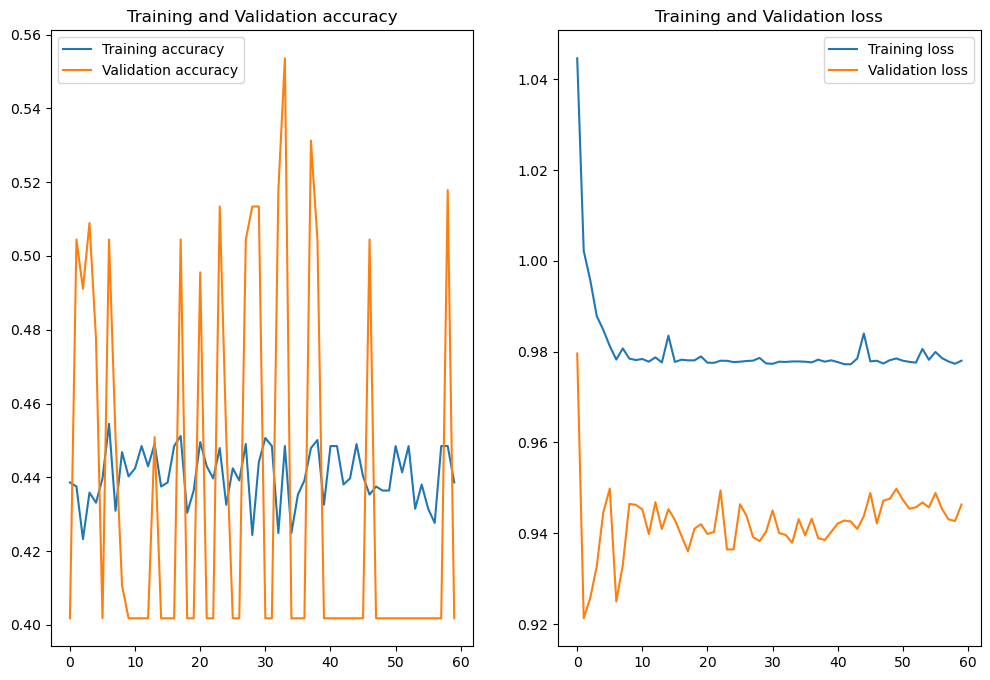

In [22]:
acc = history_model_1.history['accuracy']
val_acc = history_model_1.history['val_accuracy']

loss = history_model_1.history['loss']
val_loss = history_model_1.history['val_loss']

plt.figure(figsize=(12, 8))

plt.subplot(1,2,1)
plt.plot(range(EPOCHS), acc, label='Training accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation accuracy')
plt.legend()
plt.title('Training and Validation accuracy')

plt.subplot(1,2,2)
plt.plot(range(EPOCHS), loss, label='Training loss')
plt.plot(range(EPOCHS), val_loss, label='Validation loss')
plt.legend()
plt.title('Training and Validation loss')

In [42]:
model_2 = tf.keras.Sequential([
    layers.Input(shape=(None, None, 3)),
    resize_and_rescale,
    data_augmentation,

    layers.Conv2D(32, 3, padding="same", activation="relu"),
    layers.BatchNormalization(),
    layers.MaxPooling2D(),

    layers.Conv2D(64, 3, padding="same", activation="relu"),
    layers.BatchNormalization(),
    layers.MaxPooling2D(),

    layers.Conv2D(128, 3, padding="same", activation="relu"),
    layers.BatchNormalization(),
    layers.MaxPooling2D(),

    layers.GlobalAveragePooling2D(),
    layers.Dropout(0.3),
    layers.Dense(N_CLASSES, activation="softmax")
])

model_2.build()
model_2.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential (Sequential)         │ (None, 256, 256, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_1 (Sequential)       │ (None, 256, 256, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 256, 256, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 256, 256, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 128, 128, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 128, 128, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 128, 128, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 64, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 64, 64, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 64, 64, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 32, 32, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 128)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 3)              │           387 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 94,531 (369.26 KB)

 Trainable params: 94,083 (367.51 KB)

 Non-trainable params: 448 (1.75 KB)

In [46]:
model_2.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics=["accuracy"]
)

history_model_2 = model_2.fit(
    train_ds,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    verbose=1,
    validation_data=validation_ds
)

Epoch 1/60
57/57 ━━━━━━━━━━━━━━━━━━━━ 53s 901ms/step - accuracy: 0.4167 - loss: 1.1353 - val_accuracy: 0.5045 - val_loss: 0.9438
Epoch 2/60
57/57 ━━━━━━━━━━━━━━━━━━━━ 50s 872ms/step - accuracy: 0.4424 - loss: 1.0481 - val_accuracy: 0.5045 - val_loss: 0.9417
Epoch 3/60
57/57 ━━━━━━━━━━━━━━━━━━━━ 49s 854ms/step - accuracy: 0.4282 - loss: 1.0267 - val_accuracy: 0.4018 - val_loss: 0.9741
Epoch 4/60
57/57 ━━━━━━━━━━━━━━━━━━━━ 50s 873ms/step - accuracy: 0.4221 - loss: 1.0173 - val_accuracy: 0.4018 - val_loss: 0.9611
Epoch 5/60
57/57 ━━━━━━━━━━━━━━━━━━━━ 49s 859ms/step - accuracy: 0.4364 - loss: 1.0089 - val_accuracy: 0.5045 - val_loss: 0.9747
Epoch 6/60
57/57 ━━━━━━━━━━━━━━━━━━━━ 49s 867ms/step - accuracy: 0.4408 - loss: 1.0145 - val_accuracy: 0.4018 - val_loss: 0.9455
Epoch 7/60
57/57 ━━━━━━━━━━━━━━━━━━━━ 49s 862ms/step - accuracy: 0.4490 - loss: 1.0024 - val_accuracy: 0.5045 - val_loss: 0.9475
Epoch 8/60
57/57 ━━━━━━━━━━━━━━━━━━━━ 49s 867ms/step - accuracy: 0.4479 - loss: 1.0004 - val_accu

ValueError: invalid literal for int() with base 10: '1.keras'

In [58]:
save_model(model_2, 'potato_earlyblight_lateblight_healthy_custom_model', '2')

Model saved succesfully


In [48]:
score = model_2.evaluate(test_ds)

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 157ms/step - accuracy: 0.4068 - loss: 0.9847


Text(0.5, 1.0, 'Training and Validation loss')

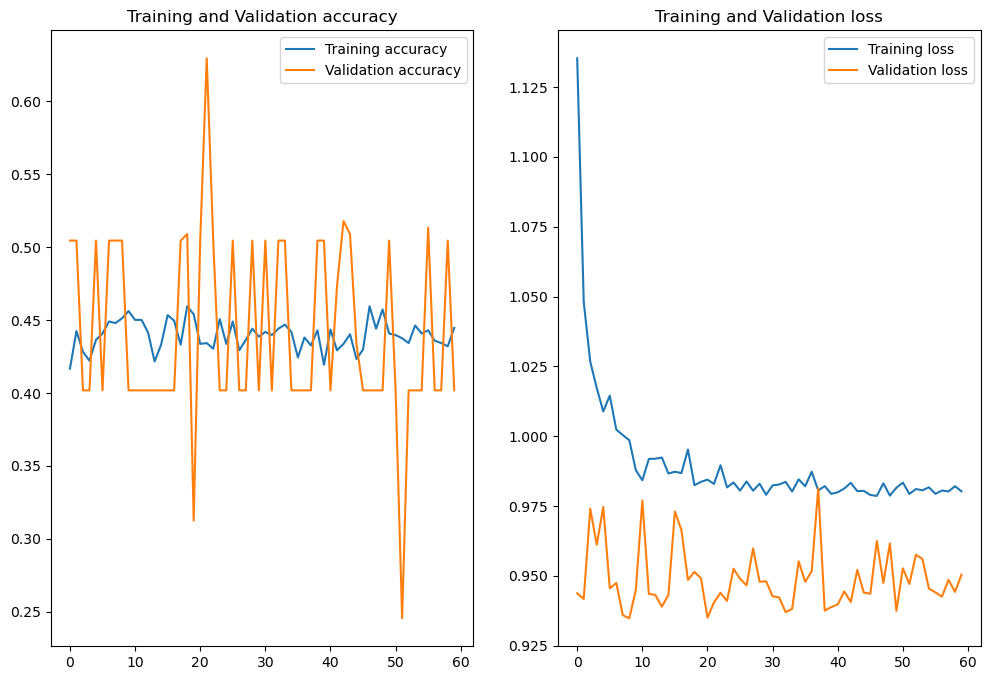

In [50]:
acc = history_model_2.history['accuracy']
val_acc = history_model_2.history['val_accuracy']

loss = history_model_2.history['loss']
val_loss = history_model_2.history['val_loss']

plt.figure(figsize=(12, 8))

plt.subplot(1,2,1)
plt.plot(range(EPOCHS), acc, label='Training accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation accuracy')
plt.legend()
plt.title('Training and Validation accuracy')

plt.subplot(1,2,2)
plt.plot(range(EPOCHS), loss, label='Training loss')
plt.plot(range(EPOCHS), val_loss, label='Validation loss')
plt.legend()
plt.title('Training and Validation loss')

In [70]:
model_3 = tf.keras.Sequential([
    layers.Input(shape=(None, None, 3)),
    
    resize_and_rescale,
    data_augmentation_2,
    
    layers.Conv2D(32, (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(N_CLASSES, activation='softmax')
])

model_3.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics=["accuracy"]
)

history_model_3 = model_3.fit(
    train_ds,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    verbose=1,
    validation_data=validation_ds
)

save_model(model_3, 'potato_earlyblight_lateblight_healthy_custom_model', '3')

Epoch 1/60
57/57 ━━━━━━━━━━━━━━━━━━━━ 28s 475ms/step - accuracy: 0.4962 - loss: 0.9504 - val_accuracy: 0.5938 - val_loss: 0.8986
Epoch 2/60
57/57 ━━━━━━━━━━━━━━━━━━━━ 27s 471ms/step - accuracy: 0.7259 - loss: 0.6518 - val_accuracy: 0.7277 - val_loss: 0.6519
Epoch 3/60
57/57 ━━━━━━━━━━━━━━━━━━━━ 27s 470ms/step - accuracy: 0.8706 - loss: 0.3455 - val_accuracy: 0.7768 - val_loss: 0.7171
Epoch 4/60
57/57 ━━━━━━━━━━━━━━━━━━━━ 27s 472ms/step - accuracy: 0.8854 - loss: 0.3266 - val_accuracy: 0.8616 - val_loss: 0.2918
Epoch 5/60
57/57 ━━━━━━━━━━━━━━━━━━━━ 27s 471ms/step - accuracy: 0.9490 - loss: 0.1408 - val_accuracy: 0.9241 - val_loss: 0.1898
Epoch 6/60
57/57 ━━━━━━━━━━━━━━━━━━━━ 27s 473ms/step - accuracy: 0.9534 - loss: 0.1334 - val_accuracy: 0.8214 - val_loss: 0.5318
Epoch 7/60
57/57 ━━━━━━━━━━━━━━━━━━━━ 27s 469ms/step - accuracy: 0.9578 - loss: 0.1374 - val_accuracy: 0.9554 - val_loss: 0.0937
Epoch 8/60
57/57 ━━━━━━━━━━━━━━━━━━━━ 27s 471ms/step - accuracy: 0.9649 - loss: 0.1200 - val_accu

In [72]:
score = model_3.evaluate(test_ds)

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 122ms/step - accuracy: 0.9915 - loss: 0.0137


Text(0.5, 1.0, 'Training and Validation loss')

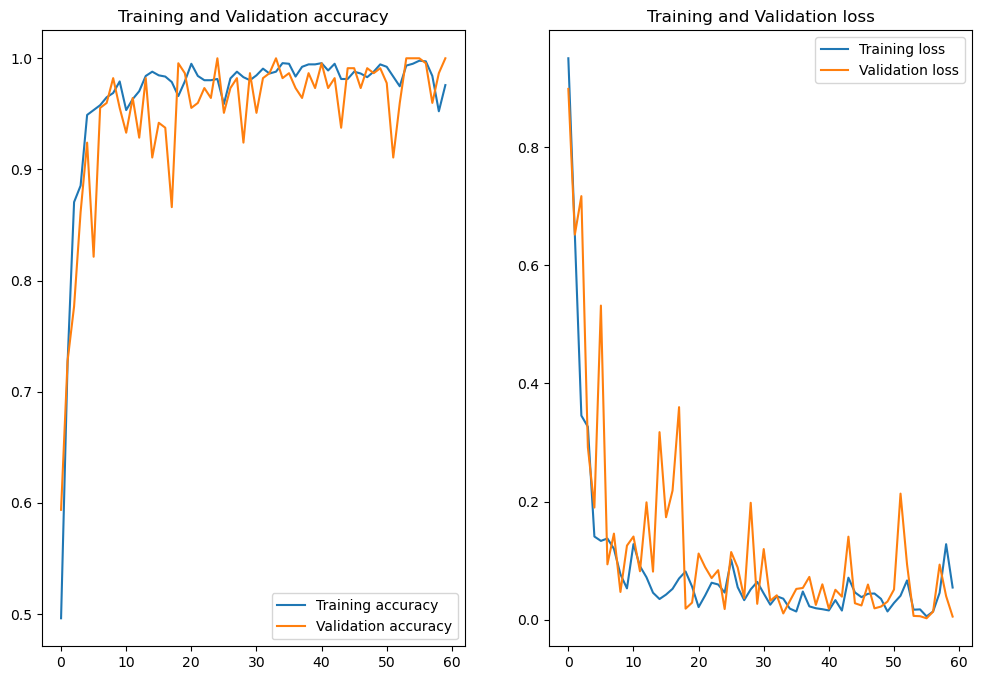

In [74]:
acc = history_model_3.history['accuracy']
val_acc = history_model_3.history['val_accuracy']

loss = history_model_3.history['loss']
val_loss = history_model_3.history['val_loss']

plt.figure(figsize=(12, 8))

plt.subplot(1,2,1)
plt.plot(range(EPOCHS), acc, label='Training accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation accuracy')
plt.legend()
plt.title('Training and Validation accuracy')

plt.subplot(1,2,2)
plt.plot(range(EPOCHS), loss, label='Training loss')
plt.plot(range(EPOCHS), val_loss, label='Validation loss')
plt.legend()
plt.title('Training and Validation loss')

### Model testing

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


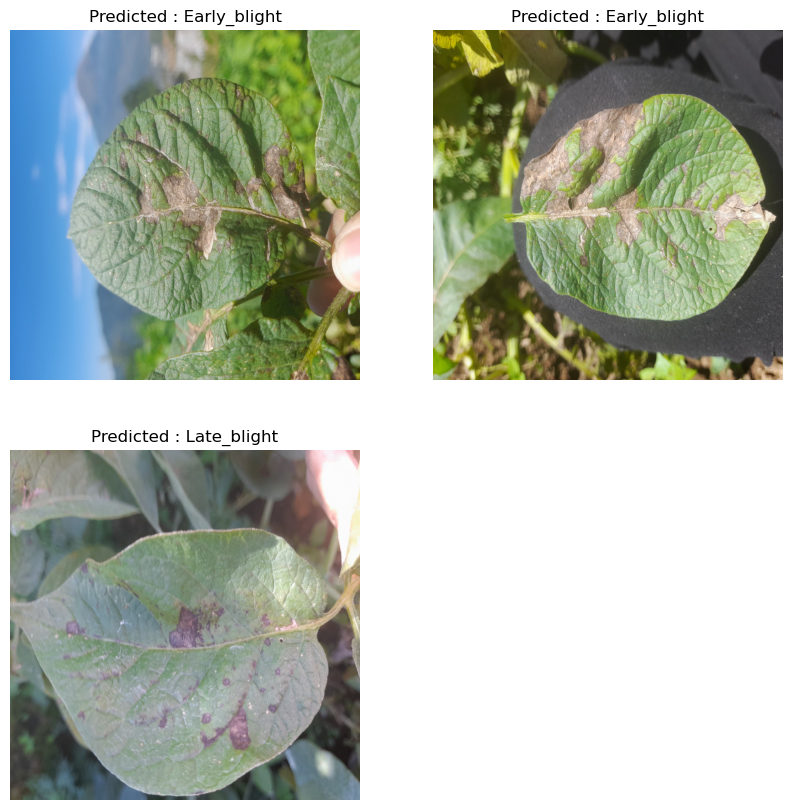

In [124]:
test_imgs = ['20230712_114552.jpg', '20230712_115213.jpg', '20230712_122415.jpg']
plt.figure(figsize=(10,10))

for i in range(len(test_imgs)):
    plt.subplot(2,2,i+1)
    img = cv.cvtColor(cv.imread(f'Extranal_tests//Blight//{test_imgs[i]}'), cv.COLOR_BGR2RGB)
    plt.imshow(img)
    plt.axis('off')
    predict = model_3.predict(tf.expand_dims(img, axis=0))
    plt.title(f'Predicted : {class_names[np.argmax(predict[0])]}')
    
    

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


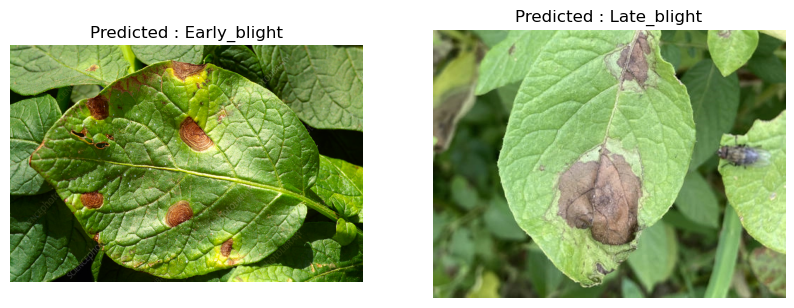

In [120]:
# test_imgs = ['20230712_114552.jpg', '20230712_115213.jpg', '20230712_122415.jpg']
test_imgs = ['Early Blight.png', 'Late Blight.png']
plt.figure(figsize=(10,10))

for i in range(len(test_imgs)):
    plt.subplot(2,2,i+1)
    img = cv.cvtColor(cv.imread(f'Extranal_tests//Blight//{test_imgs[i]}'), cv.COLOR_BGR2RGB)
    plt.imshow(img)
    plt.axis('off')
    predict = model_3.predict(tf.expand_dims(img, axis=0))
    plt.title(f'Predicted : {class_names[np.argmax(predict[0])]}')
    
    

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


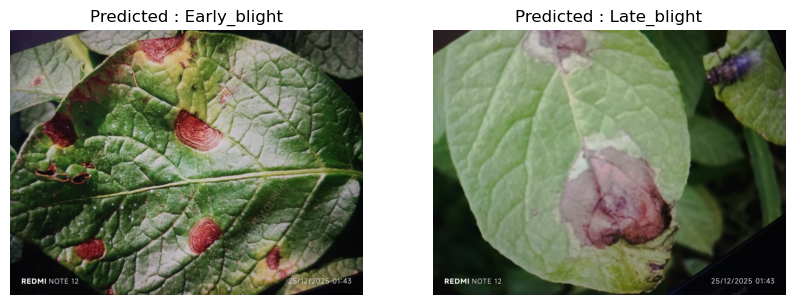

In [122]:

test_imgs = ['Early1.jpeg', 'Late1.jpeg']
plt.figure(figsize=(10,10))

for i in range(len(test_imgs)):
    plt.subplot(2,2,i+1)
    img = cv.cvtColor(cv.imread(f'Extranal_tests//Blight//{test_imgs[i]}'), cv.COLOR_BGR2RGB)
    plt.imshow(img)
    plt.axis('off')
    predict = model_3.predict(tf.expand_dims(img, axis=0))
    plt.title(f'Predicted : {class_names[np.argmax(predict[0])]}')